In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

## 1. Inspecting the Images

In [3]:
import random, os
infected_path = "./cell_images/Parasitized/"
uninfected_path = "./cell_images/Uninfected/"

#Create a list of filenames of infected and uninfected cells
infected_filenames = os.listdir(infected_path)
uninfected_filenames = os.listdir(uninfected_path)

In [4]:
#Check the total number of images
print('Number of infected images: ',len(infected_filenames))
print('Number of uninfected images',len(uninfected_filenames))

Number of infected images:  13779
Number of uninfected images 13779


In [5]:
#Create samples of 6 images of infected and uninfected cells for viewing
random.seed(99)
infected_sample = random.sample(infected_filenames,6)
random.seed(99)
uninfect_sample = random.sample(uninfected_filenames,6)

In [6]:
def show_images(folder_path,image_names,n_rows,n_cols):
    '''
    This function prints out multiple images.
    IN: path to image folder, list of image names, number of of rows, number of columns
    '''
    #Create a set of subplots
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
    
    #Read in and plot the images
    for index in range(len(image_names)):
        #Read in the image
        image = plt.imread(folder_path+image_names[index])
        #Plot the image, filling each row from left to right
        ax[index//n_cols][index%n_cols].imshow(image) 

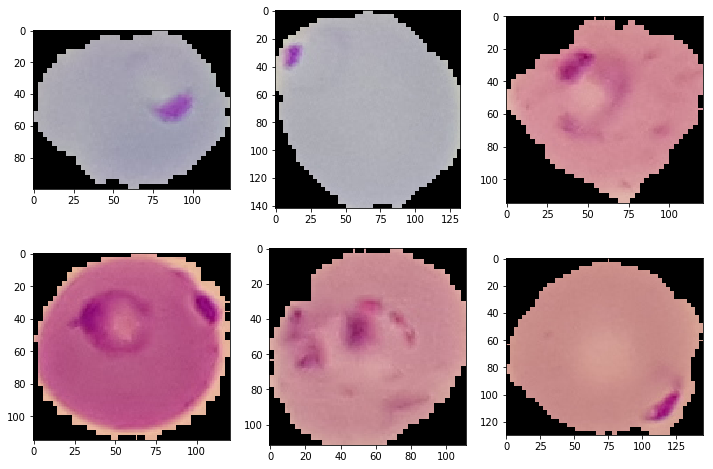

In [7]:
#View the infected samples
show_images(infected_path,infected_sample,2,3)

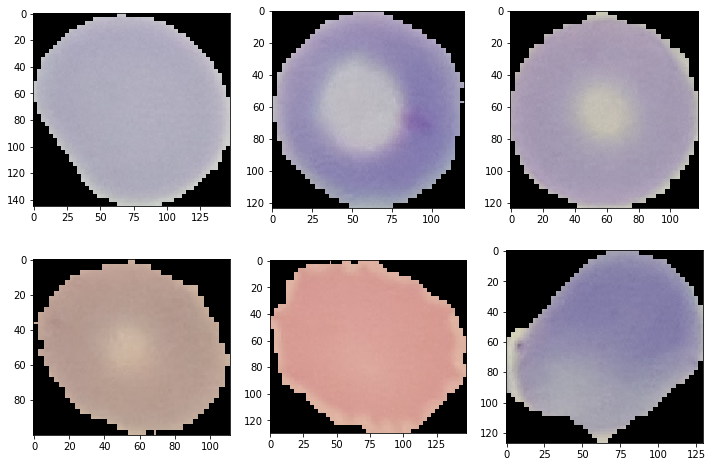

In [8]:
#View the uninfected samples
show_images(uninfected_path,uninfect_sample,2,3)

<div class='alert alert-block alert-info'>
    There seem to be rather distinct differences between the infect and uninfected cells (at least from these samples), the neural network should be able to distinguish between them relatively easily.
</div>

## 2. Preparing the Images

In [9]:
from shutil import copy2

In [10]:
#Create folders for train and test
try:
    os.makedirs('./train/Parasitized')
except:
    print('Unable to create folder, folder may already exist')

try:
    os.makedirs('./train/Uninfected')
except:
    print('Unable to create folder, folder may already exist')

try:
    os.makedirs('./test/test_imgs')
except:
    print('Unable to create folder, folder may already exist')

Unable to create folder, folder may already exist
Unable to create folder, folder may already exist
Unable to create folder, folder may already exist


In [11]:
#Split files into training and test sets
uninfected_train, uninfected_test, infected_train, infected_test = train_test_split(uninfected_filenames, infected_filenames, test_size=0.3, random_state=42)

In [12]:
#Copy train images to train folder
for name in uninfected_train:
    copy2(uninfected_path+name,'./train/Uninfected/'+name)

for name in infected_train:
    copy2(infected_path+name,'./train/Parasitized/'+name)

In [13]:
#Copy test images to test folder
for name in uninfected_test:
    copy2(uninfected_path+name,'./test/test_imgs/'+name)

for name in infected_test:
    copy2(infected_path+name,'./test/test_imgs/'+name)

In [14]:
#Create a DataFrame to record the infected status of the test images
image_list = []
cat_list = []
for image in os.listdir('./test/test_imgs/'):
    image_list.append('./test/test_imgs/'+image)
    if image in infected_test:
        cat_list.append(1)
    else:
        cat_list.append(0)

test_df = pd.DataFrame({'image_paths':image_list,'Infected?':cat_list})

In [15]:
test_df.head()

,image_paths,Infected?
0,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,0
1,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,1
2,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,1
3,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,1
4,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,0


In [16]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [17]:
#Create image generators for training, validation and test sets
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
#Create training set using the training generator
BATCH_SIZE = 32

training_set = train_datagen.flow_from_directory(
                                                    './train/',
                                                    target_size=(64, 64),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    subset='training')

#Create validation set using the training generator
validation_set = train_datagen.flow_from_directory(
                                                    './train/',
                                                    target_size=(64, 64),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    subset='validation')
#Create test set using the test generator
test_set = test_datagen.flow_from_directory(
                                                './test/',
                                                target_size=(64, 64),
                                                batch_size=1,
                                                class_mode=None,
                                                shuffle=False)

Found 17362 images belonging to 2 classes.
Found 1928 images belonging to 2 classes.
Found 8268 images belonging to 1 classes.


## 3. Modelling

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Dense
from keras.callbacks import ReduceLROnPlateau

In [20]:
#Build the model
model=Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

In [22]:
#Train and validate the model
model_training = model.fit_generator(training_set,
                                     steps_per_epoch=training_set.samples/BATCH_SIZE,
                                     validation_data=validation_set,
                                     validation_steps=validation_set.samples/BATCH_SIZE,
                                     verbose=1,
                                     epochs=50)

Epoch 1/50
543/542 [==============================] - 41s 76ms/step - loss: 0.5539 - acc: 0.7130 - val_loss: 0.3039 - val_acc: 0.8791
Epoch 2/50
543/542 [==============================] - 38s 71ms/step - loss: 0.2861 - acc: 0.8917 - val_loss: 0.2973 - val_acc: 0.8926
Epoch 3/50
543/542 [==============================] - 36s 66ms/step - loss: 0.2515 - acc: 0.9073 - val_loss: 0.2639 - val_acc: 0.9046
Epoch 4/50
543/542 [==============================] - 35s 65ms/step - loss: 0.2219 - acc: 0.9202 - val_loss: 0.2524 - val_acc: 0.9170
Epoch 5/50
543/542 [==============================] - 38s 69ms/step - loss: 0.2121 - acc: 0.9265 - val_loss: 0.2430 - val_acc: 0.8952
Epoch 6/50
543/542 [==============================] - 35s 65ms/step - loss: 0.1984 - acc: 0.9343 - val_loss: 0.2378 - val_acc: 0.9009
Epoch 7/50
543/542 [==============================] - 35s 65ms/step - loss: 0.1888 - acc: 0.9388 - val_loss: 0.2424 - val_acc: 0.8719
Epoch 8/50
543/542 [==============================] - 37s 67ms

Text(0, 0.5, 'Accuracy')

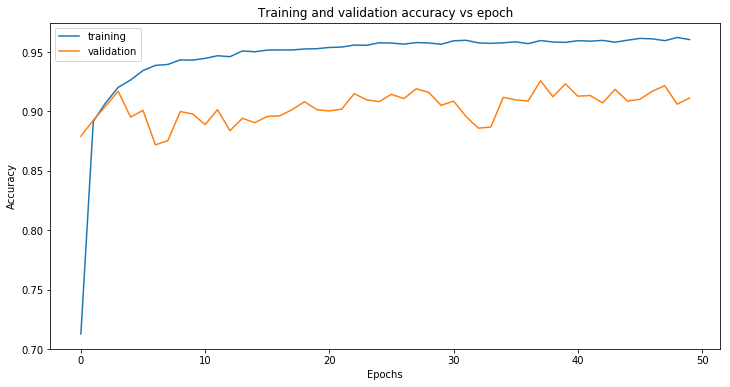

In [23]:
#Plot training and validation accuracy vs epoch
plt.figure(figsize=(12,6))
plt.plot(model_training.history['acc'],label='training')
plt.plot(model_training.history['val_acc'],label='validation')
plt.legend()

plt.title('Training and validation accuracy vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

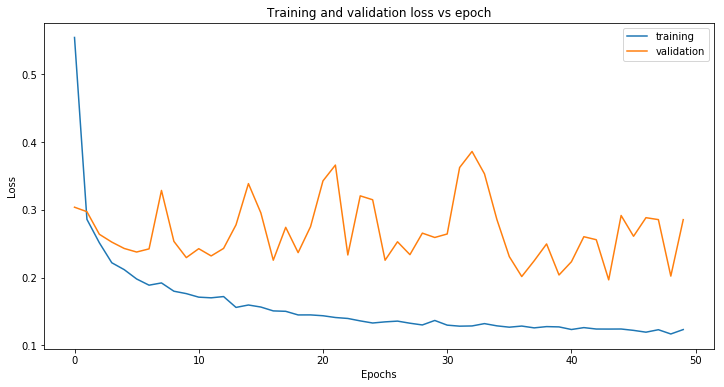

In [24]:
#Plot training and validation loss vs epoch
plt.figure(figsize=(12,6))
plt.plot(model_training.history['loss'],label='training')
plt.plot(model_training.history['val_loss'],label='validation')
plt.legend()

plt.title('Training and validation loss vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

<div class='alert alert-block alert-info'>
    Model starts to stabilize around 30 epochs.
</div>

In [25]:
#Save the model
model.save('first_model.hf5')

## Testing and Evaluation

In [26]:
#Get predicted probabilities
test_set.reset()
predictions = model.predict_generator(test_set,steps=test_set.samples)

In [27]:
#Check the classes
training_set.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [28]:
#Set the predicted classes from the probabilities
predicted_classes = [1 if prob >0.5 else 0 for prob in predictions]

In [29]:
#Remove the infected? column and add an uninfected column to match the class numbering of the model
test_df['uninfected'] = [1 if num == 0 else 0 for num in test_df['Infected?']]
test_df.drop('Infected?',axis=1,inplace=True)

In [30]:
print(classification_report(test_df['uninfected'],predicted_classes))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4134
           1       0.94      0.98      0.96      4134

   micro avg       0.95      0.95      0.95      8268
   macro avg       0.96      0.95      0.95      8268
weighted avg       0.96      0.95      0.95      8268



In [31]:
pd.DataFrame(data=confusion_matrix(test_df['uninfected'],predicted_classes),
            columns=['Pred Infected','Pred Uninfected'],
            index=['Real Infected','Real Uninfected'])

,Pred Infected,Pred Uninfected
Real Infected,3855,279
Real Uninfected,99,4035


In [32]:
#Add predictions to the table
test_df['predictions']=predicted_classes

In [33]:
#Find the cells that were false identified as uninfected
false_uninfected = test_df.loc[(test_df['predictions'] != test_df['uninfected']) & test_df['predictions']==1]

In [34]:
false_uninfected.head()

,image_paths,uninfected,predictions
8,./test/test_imgs/C100P61ThinF_IMG_20150918_144...,0,1
124,./test/test_imgs/C101P62ThinF_IMG_20150923_165...,0,1
139,./test/test_imgs/C101P62ThinF_IMG_20150923_170...,0,1
163,./test/test_imgs/C102P63ThinF_IMG_20150918_161...,0,1
169,./test/test_imgs/C102P63ThinF_IMG_20150918_162...,0,1


In [35]:
#Get a sample of the cells falsely identified as uninfected
random.seed(99)
false_uninfected_samples = random.sample(set(false_uninfected['image_paths']),16)

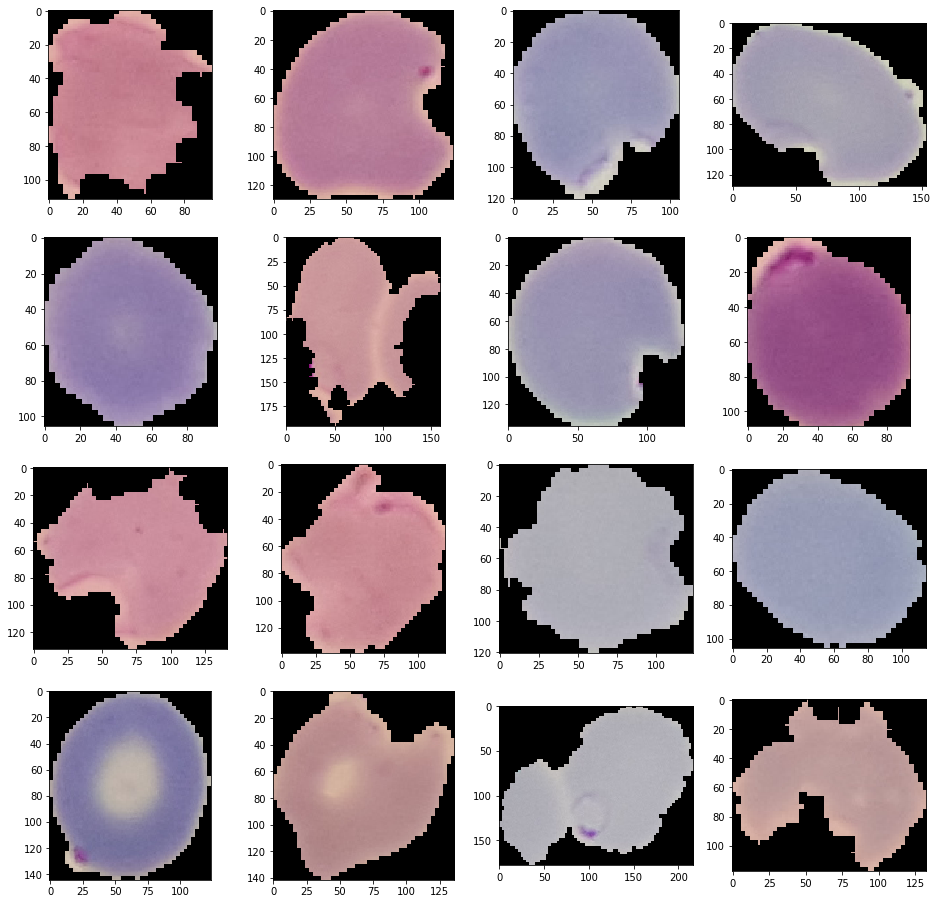

In [36]:
#View the sample of the cells falsely identified as uninfected
show_images('',false_uninfected_samples,4,4)

In [37]:
from sklearn.metrics import auc, roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(test_df['uninfected'],predictions)
roc_auc = auc(fpr,tpr)

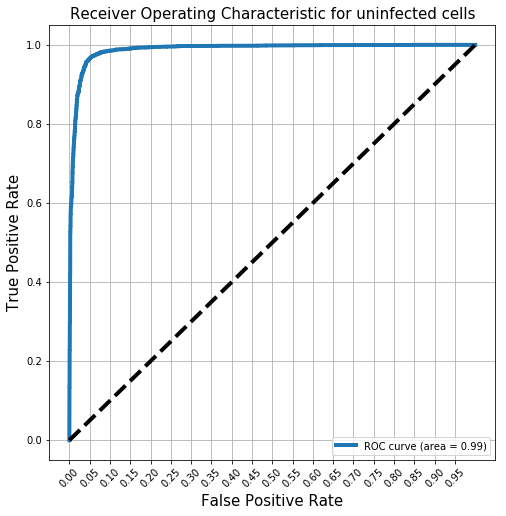

In [39]:
#Plot the AUC ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth =4)
plt.plot([0,1],[0,1], 'k--', linewidth=4)

plt.xlim([-0.05,1.0])
plt.xlim([-0.05,1.05])
plt.xticks(np.arange(0,1,0.05),rotation = 45)
plt.grid()

plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic for uninfected cells', fontsize=15)
plt.legend(loc='lower right')

In [40]:
df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds})

In [41]:
#Check fpr and tpr at current threshold of 0.5
df[(df['threshold']>=0.5) & (df['threshold']<=0.55)].sort_values('threshold')

,fpr,tpr,threshold
737,0.066038,0.976052,0.513624
736,0.066038,0.975568,0.516359
735,0.065796,0.975568,0.520846
734,0.065796,0.974843,0.526010
733,0.065312,0.974843,0.531161
732,0.065312,0.974601,0.534696
731,0.064586,0.974601,0.539287
730,0.064586,0.974359,0.540745
729,0.064344,0.974359,0.548301


In [42]:
#Looking at the curve, at about 0.8 the false positive rate starts approaching zero.
df[(df['tpr']>=0.8) & (df['tpr']<=0.81)].sort_values('threshold')

,fpr,tpr,threshold
475,0.014756,0.805999,0.991597
474,0.014514,0.805999,0.991598
473,0.014514,0.804790,0.991700
472,0.014272,0.804790,0.991722


In [43]:
#Check what threshold would bring the false positive rate down to 5%
df[(df['fpr']>=0.05) & (df['fpr']<=0.053)].sort_values('threshold')

,fpr,tpr,threshold
696,0.052733,0.968312,0.724599
695,0.052733,0.968070,0.728757
694,0.051524,0.968070,0.734587
693,0.051524,0.967344,0.739236
692,0.051282,0.967344,0.744049
691,0.051282,0.966376,0.752596
690,0.051040,0.966376,0.753443
689,0.051040,0.966134,0.757291
688,0.050556,0.966134,0.761430
687,0.050556,0.964925,0.767272


<div class='alert alert-block alert-info'>
    The model did rather well, however there were still a rather high amount of cells misclassified as uninfected (about 7%). By adjusting the threshold, we would be able to lower the number of cells misclassified as uninfected, with the tradeoff of greater misclassifications of infected cells, which would likely be easier to handle with a follow-up diagnostic, than a patient going back thinking he/she is fine. The model could also be tuned or trained at a higher resolution to try to achieve get better results. 
</div>